<a href="https://colab.research.google.com/github/ggzone/Modern-Computer-Vision-with-PyTorch/blob/master/Chapter10/crowd_counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%time
import os
if not os.path.exists('CSRNet-pytorch/'):
    !pip install -U scipy torch_snippets torch_summary
    !git clone https://github.com/sizhky/CSRNet-pytorch.git
    from google.colab import files
    files.upload() # upload kaggle.json
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !ls ~/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json
    print('downloading data...')
    !kaggle datasets download -d tthien/shanghaitech-with-people-density-map/
    print('unzipping data...')
    !unzip -qq shanghaitech-with-people-density-map.zip

%cd CSRNet-pytorch
!ln -s ../shanghaitech_with_people_density_map
from torch_snippets import *
import h5py
from scipy import io

/content/CSRNet-pytorch
ln: failed to create symbolic link './shanghaitech_with_people_density_map': File exists
CPU times: user 1.08 s, sys: 165 ms, total: 1.24 s
Wall time: 1.23 s


In [2]:
!pwd

/content/CSRNet-pytorch


In [3]:
part_A = Glob('shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/');

image_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/images/'
heatmap_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/ground-truth-h5/'
gt_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data/ground-truth/'

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torch_snippets import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tfm = T.Compose([
    T.ToTensor()
])

class Crowds(Dataset):
    def __init__(self, stems):
        self.stems = stems

    def __len__(self):
        return len(self.stems)

    def __getitem__(self, ix):
        _stem = self.stems[ix]
        image_path = f'{image_folder}/{_stem}.jpg'
        heatmap_path = f'{heatmap_folder}/{_stem}.h5'
        gt_path = f'{gt_folder}/GT_{_stem}.mat'

        import scipy.io as io
        pts = io.loadmat(gt_path)
        pts = len(pts['image_info'][0,0][0,0][0])

        image = read(image_path, 1)
        with h5py.File(heatmap_path, 'r') as hf:
            gt = hf['density'][:]
        gt = resize(gt, 1/8)*64
        return image.copy(), gt.copy(), pts

    def collate_fn(self, batch):
        ims, gts, pts = list(zip(*batch))
        ims = torch.cat([tfm(im)[None] for im in ims]).to(device)
        gts = torch.cat([tfm(gt)[None] for gt in gts]).to(device)
        return ims, gts, torch.tensor(pts).to(device)

    def choose(self):
        return self[randint(len(self))]

from sklearn.model_selection import train_test_split
trn_stems, val_stems = train_test_split(stems(Glob(image_folder)), random_state=10)

trn_ds = Crowds(trn_stems)
val_ds = Crowds(val_stems)

trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

In [5]:
import torch.nn as nn
import torch
from torchvision import models
from utils import save_net,load_net

def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [6]:
class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            items = list(self.frontend.state_dict().items())
            _items = list(mod.state_dict().items())
            for i in range(len(self.frontend.state_dict().items())):
                items[i][1].data[:] = _items[i][1].data[:]
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [7]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    ims, gts, pts = data
    _gts = model(ims)
    loss = criterion(_gts, gts)
    loss.backward()
    optimizer.step()
    pts_loss = nn.L1Loss()(_gts.sum(), gts.sum())
    return loss.item(), pts_loss.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, gts, pts = data
    _gts = model(ims)
    loss = criterion(_gts, gts)
    pts_loss = nn.L1Loss()(_gts.sum(), gts.sum())
    return loss.item(), pts_loss.item()

In [12]:
model = CSRNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
n_epochs = 20

from torch_snippets.torch_loader import Report
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, pts_loss = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_pts_loss=pts_loss, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, pts_loss = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_pts_loss=pts_loss, end='\r')

    log.report_avgs(ex+1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EPOCH: 1.000  trn_pts_loss: 423.819  val_pts_loss: 329.229  trn_loss: 0.048  val_loss: 0.056  (80.30s - 1525.68s remaining)
EPOCH: 2.000  trn_pts_loss: 316.936  val_pts_loss: 296.827  trn_loss: 0.041  val_loss: 0.051  (158.34s - 1425.05s remaining)
EPOCH: 3.000  trn_pts_loss: 234.728  val_pts_loss: 205.406  trn_loss: 0.036  val_loss: 0.045  (237.74s - 1347.21s remaining)
EPOCH: 4.000  trn_pts_loss: 160.542  val_pts_loss: 188.624  trn_loss: 0.033  val_loss: 0.043  (317.83s - 1271.31s remaining)
EPOCH: 5.000  trn_pts_loss: 148.078  val_pts_loss: 194.656  trn_loss: 0.032  val_loss: 0.043  (398.19s - 1194.58s remaining)
EPOCH: 6.000  trn_pts_loss: 152.334  val_pts_loss: 182.603  trn_loss: 0.031  val_loss: 0.041  (478.63s - 1116.80s remaining)
EPOCH: 7.000  trn_pts_loss: 131.198  val_pts_loss: 172.562  trn_loss: 0.031  val_loss: 0.041  (559.07s - 1038.28s remaining)
EPOCH: 8.000  trn_pts_loss: 137.062  val_pts_loss: 159.803  trn_loss: 0.030  val_loss: 0.039  (639.42s - 959.13s remaining)
EP

In [13]:
from matplotlib import cm as c
from torchvision import datasets, transforms
from PIL import Image
transform=transforms.Compose([
                      transforms.ToTensor(),transforms.Normalize(
                          mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
                  ])

test_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/'
imgs = Glob(f'{test_folder}/images')
f = choose(imgs)
print(f)
img = transform(Image.open(f).convert('RGB')).to(device)

[12/29/24 09:02:15] INFO     Chose `shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/images/IMG_100.jpg` from input                   ]8;id=582133;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/loader.py:187\loader.py]8;;\:]8;id=795866;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/loader.py:187#choose:187\choose:187]8;;\

shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/images/IMG_100.jpg


Predicted Count :  285


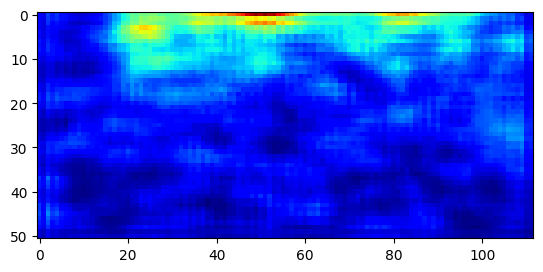

In [15]:
import matplotlib.pyplot as plt
output = model(img[None])
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()

In [ ]:
#显示照片f

In [ ]:
from matplotlib import cm as c
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt # Import the pyplot module

transform=transforms.Compose([
                      transforms.ToTensor(),transforms.Normalize(
                          mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
                  ])

test_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/'
imgs = Glob(f'{test_folder}/images')
f = choose(imgs)
print(f)

# Display the image f
img_f = Image.open(f).convert('RGB') # Open the image
plt.imshow(img_f

[12/29/24 09:05:12] INFO     Chose `shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/images/IMG_15.jpg` from input                    ]8;id=238270;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/loader.py:187\loader.py]8;;\:]8;id=829448;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/loader.py:187#choose:187\choose:187]8;;\

shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/images/IMG_15.jpg


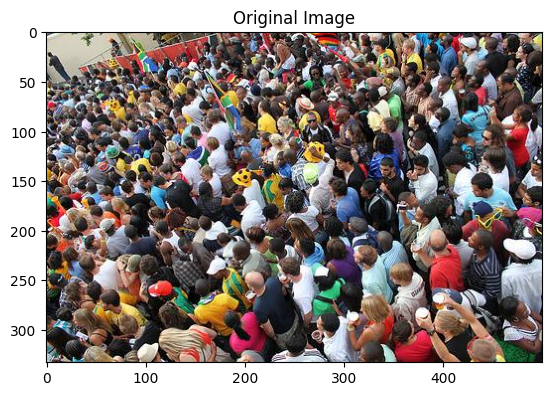

Predicted Count :  210


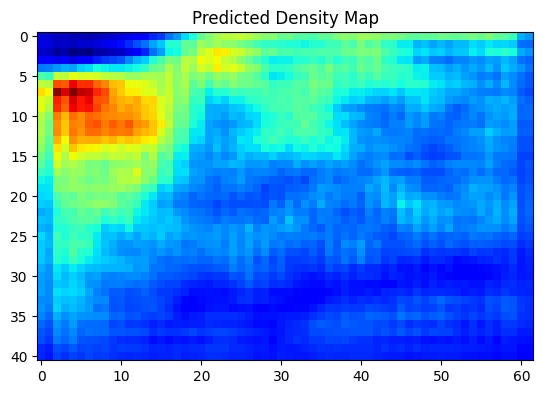

In [16]:
from matplotlib import cm as c
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt # Import the pyplot module

transform=transforms.Compose([
                      transforms.ToTensor(),transforms.Normalize(
                          mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
                  ])

test_folder = 'shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data/'
imgs = Glob(f'{test_folder}/images')
f = choose(imgs)
print(f)

# Display the image f
img_f = Image.open(f).convert('RGB') # Open the image
plt.imshow(img_f) # Display using matplotlib.pyplot
plt.title("Original Image") # Set title
plt.show() # Show the image

img = transform(img_f).to(device) # Apply transformations for the model

output = model(img[None])
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.title("Predicted Density Map") # Set title for the density map
plt.show()